### <span style='color:#ff5f27'> Imports

In [82]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import hopsworks

import warnings
warnings.filterwarnings("ignore")

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline with Lag Features</span>

In [83]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip any parent directories to add the root_dir to the PYTHON_PATH 
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [84]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store()

2026-01-10 14:05:50,311 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-10 14:05:50,321 INFO: Initializing external client
2026-01-10 14:05:50,323 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-10 14:05:51,877 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


In [85]:
# Retrieve feature groups
energy_fg = fs.get_feature_group(
    name='energy_consumption',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> Feature View Creation and Retrieving </span>

In [86]:
# Select features for training data (WITH lag features)
selected_features = energy_fg.select([
    'consumption_mw', 'date',
    'year', 'month', 'day', 'hour',
    'day_of_week', 'is_weekend', 'week_of_year'
]).join(weather_fg.select_features(), on=['country'])

print("Selected features: temporal + weather (lag features will be added locally)")

2026-01-10 14:05:53,952 INFO: Using ['temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation'] from feature group `weather_finland` as features for the query. To include primary key and event time use `select_all`.
Selected features: temporal + weather (lag features will be added locally)


In [87]:
feature_view = fs.get_or_create_feature_view(
    name='energy_consumption_fv_with_lags',
    description="Temporal and weather features with energy consumption as target (lag features added locally)",
    version=1,
    labels=['consumption_mw'],
    query=selected_features,
)

## <span style="color:#ff5f27;">Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [88]:
# Test on September 2025 data, train on all other data
# Filter feature view to get all available data, then split by September month

# Read data from feature view efficiently
all_data = feature_view.query.read()

# Convert to pandas if needed
if not isinstance(all_data, pd.DataFrame):
    all_data = all_data.toPandas()

# Sort by date globally to ensure proper lag calculation
all_data = all_data.sort_values('date').reset_index(drop=True)

# Split by month and year: September 2025 for testing, all other data for training
test_month = 9
test_year = 2025
test_indices = (all_data['month'] == test_month) & (all_data['year'] == test_year)

print(f"Total data: {len(all_data)} samples")
print(f"Testing on September 2025 data: {test_indices.sum()} samples")
print(f"Training on all other data: {(~test_indices).sum()} samples")
print(f"\nTest set date range:")
test_data_preview = all_data[test_indices]
if len(test_data_preview) > 0:
    print(f"  Start: {test_data_preview['date'].min()}")
    print(f"  End: {test_data_preview['date'].max()}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.62s) 
Total data: 384519 samples
Testing on September 2025 data: 14394 samples
Training on all other data: 370125 samples

Test set date range:
  Start: 2025-09-01 00:00:00+00:00
  End: 2025-09-30 23:57:00+00:00


## <span style="color:#ff5f27;">Create Lag Features</span>

Add lag features for consumption (1 hour, 24 hours, 7 days)

In [89]:
# Create lag features on the full sorted dataset
# Group by day to create lags properly (in case there are gaps in hourly data)
lag_hours = [24, 48, 72]  # 1 day, 2 days, 3 days (in hours)

for lag in lag_hours:
    all_data[f'consumption_lag_{lag}h'] = all_data.groupby(all_data['date'].dt.date)['consumption_mw'].shift(lag).fillna(method='bfill').fillna(method='ffill')

print(f"Created lag features: {[f'consumption_lag_{lag}h' for lag in lag_hours]} (1-day, 2-day, 3-day lags)")
print(f"\nLag features info:")
print(all_data[[f'consumption_lag_{lag}h' for lag in lag_hours]].describe())

Created lag features: ['consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h'] (1-day, 2-day, 3-day lags)

Lag features info:
       consumption_lag_24h  consumption_lag_48h  consumption_lag_72h
count         384519.00000        384519.000000        384519.000000
mean            9637.66008          9625.019946          9598.531031
std             1631.87442          1635.355573          1642.383449
min             5685.80000          5685.800000          5685.800000
25%             8394.00000          8388.100000          8375.000000
50%             9438.20000          9426.900000          9402.500000
75%            10804.00000         10792.000000         10752.000000
max            15083.00000         15083.000000         15083.000000


In [90]:
# Split data after lag creation
test_data = all_data[test_indices].copy().sort_values('date').reset_index(drop=True)
train_data = all_data[~test_indices].copy().sort_values('date').reset_index(drop=True)

# Drop rows with NaN values in lag features (first few rows of each group)
train_data = train_data.dropna()
test_data = test_data.dropna()

print(f"After removing NaN from lags:")
print(f"Training data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")

After removing NaN from lags:
Training data: 370125 samples
Test data: 14394 samples


In [91]:
# Convert dates to datetime
test_data['date'] = pd.to_datetime(test_data['date'])
train_data['date'] = pd.to_datetime(train_data['date'])

print(f"Data preparation complete")
print(f"Weekends in test data: {test_data['is_weekend'].sum()}")

Data preparation complete
Weekends in test data: 3840


In [92]:
# Prepare X and y for train and test sets
X_train = train_data.drop(columns=['consumption_mw'])
y_train = train_data[['consumption_mw']]

X_test = test_data.drop(columns=['consumption_mw'])
y_test = test_data[['consumption_mw']]

In [93]:
X_train

,date,year,month,day,hour,day_of_week,is_weekend,week_of_year,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,consumption_lag_24h,consumption_lag_48h,consumption_lag_72h
0,2024-01-02 20:43:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0,14400.0,14400.0,13539.0
1,2024-01-02 20:46:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0,14400.0,14400.0,13539.0
2,2024-01-02 20:49:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0,14400.0,14400.0,13539.0
3,2024-01-02 20:52:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0,14400.0,14400.0,13539.0
4,2024-01-02 20:55:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.000000,41.666667,1021.533333,0.0,14400.0,14400.0,13539.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370120,2026-01-10 06:09:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0,14057.0,14034.0,14024.0
370121,2026-01-10 06:12:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0,14087.0,14033.0,14026.0
370122,2026-01-10 06:15:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0,14009.0,14050.0,13974.0
370123,2026-01-10 06:18:00+00:00,2026,1,10,6,5,1,2,-11.966667,0.0,100.0,31.466667,43.333333,17.333333,1011.366667,0.0,13968.0,13989.0,13946.0


In [94]:
y_train

,consumption_mw
0,14400.0
1,14366.0
2,14331.0
3,14277.0
4,14385.0
...,...
370120,14153.0
370121,14244.0
370122,14283.0
370123,14240.0


In [95]:
# Drop date column if it exists
columns_to_drop = [col for col in ['date', 'country'] if col in X_train.columns]
X_features = X_train.drop(columns=columns_to_drop)
X_test_features = X_test.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining features: {list(X_features.columns)}")
print(f"\nLag features included: {[col for col in X_features.columns if 'lag' in col]}")

Dropped columns: ['date']
Remaining features: ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h']

Lag features included: ['consumption_lag_24h', 'consumption_lag_48h', 'consumption_lag_72h']


## <span style="color:#ff5f27;">Modeling</span>

We will train 3 separate regression models: one for each lag period (1-day, 2-day, 3-day)

In [96]:
# Handle any missing values by filling with forward fill then backward fill
X_features = X_features.ffill().bfill()
X_test_features = X_test_features.ffill().bfill()

# Dictionary to store models and predictions
models = {}
predictions = {}
metrics = {}

lag_configs = {
    '1-day': ['consumption_lag_24h'],
    '2-day': ['consumption_lag_48h'],
    '3-day': ['consumption_lag_72h']
}

# Train 3 separate models
for lag_name, lag_features in lag_configs.items():
    print(f"\n{'='*60}")
    print(f"Training model with {lag_name} lag features")
    print(f"{'='*60}")
    
    # Select only the lag feature for this model + other non-lag features
    feature_cols = [col for col in X_features.columns if 'lag' not in col] + lag_features
    X_features_subset = X_features[feature_cols].copy()
    X_test_features_subset = X_test_features[feature_cols].copy()
    
    # Create and train model
    xgb_model = XGBRegressor(
        max_depth=8,
        learning_rate=0.05,
        n_estimators=300,
        random_state=42
    )
    xgb_model.fit(X_features_subset, y_train)
    
    # Make predictions
    y_pred_temp = xgb_model.predict(X_test_features_subset)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test.iloc[:,0], y_pred_temp)
    mse = mean_squared_error(y_test.iloc[:,0], y_pred_temp)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred_temp)
    
    # Store results
    models[lag_name] = xgb_model
    predictions[lag_name] = y_pred_temp
    metrics[lag_name] = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}
    
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

print(f"\n{'='*60}")
print("All 3 models trained successfully!")
print(f"{'='*60}")


Training model with 1-day lag features
MAE: 115.27
MSE: 21768.26
RMSE: 147.54
R²: 0.9474

Training model with 2-day lag features
MAE: 151.70
MSE: 37630.44
RMSE: 193.99
R²: 0.9091

Training model with 3-day lag features
MAE: 176.46
MSE: 49721.74
RMSE: 222.98
R²: 0.8799

All 3 models trained successfully!


In [97]:
# Create dataframe with all predictions and dates
df = y_test.copy()
df['date'] = X_test['date'].values

# Add predictions from all 3 models
for lag_name, y_pred_temp in predictions.items():
    df[f'predicted_{lag_name}'] = y_pred_temp

df = df.sort_values(by=['date'])
df.head()

,consumption_mw,date,predicted_1-day,predicted_2-day,predicted_3-day
0,7202.0,2025-09-01 00:00:00,7220.19873,7211.707031,7168.750977
1,7257.4,2025-09-01 00:03:00,7220.19873,7211.707031,7168.750977
2,7224.2,2025-09-01 00:06:00,7220.19873,7211.707031,7168.750977
3,7220.5,2025-09-01 00:09:00,7220.19873,7211.707031,7168.750977
4,7206.4,2025-09-01 00:12:00,7220.19873,7211.707031,7168.750977


In [98]:
# Display metrics comparison
print("\nMetrics Comparison:")
print("="*80)
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)
print("="*80)


Metrics Comparison:
              mae           mse        rmse        r2
1-day  115.272437  21768.257292  147.540697  0.947420
2-day  151.695574  37630.440846  193.985672  0.909105
3-day  176.460252  49721.738543  222.983718  0.879899


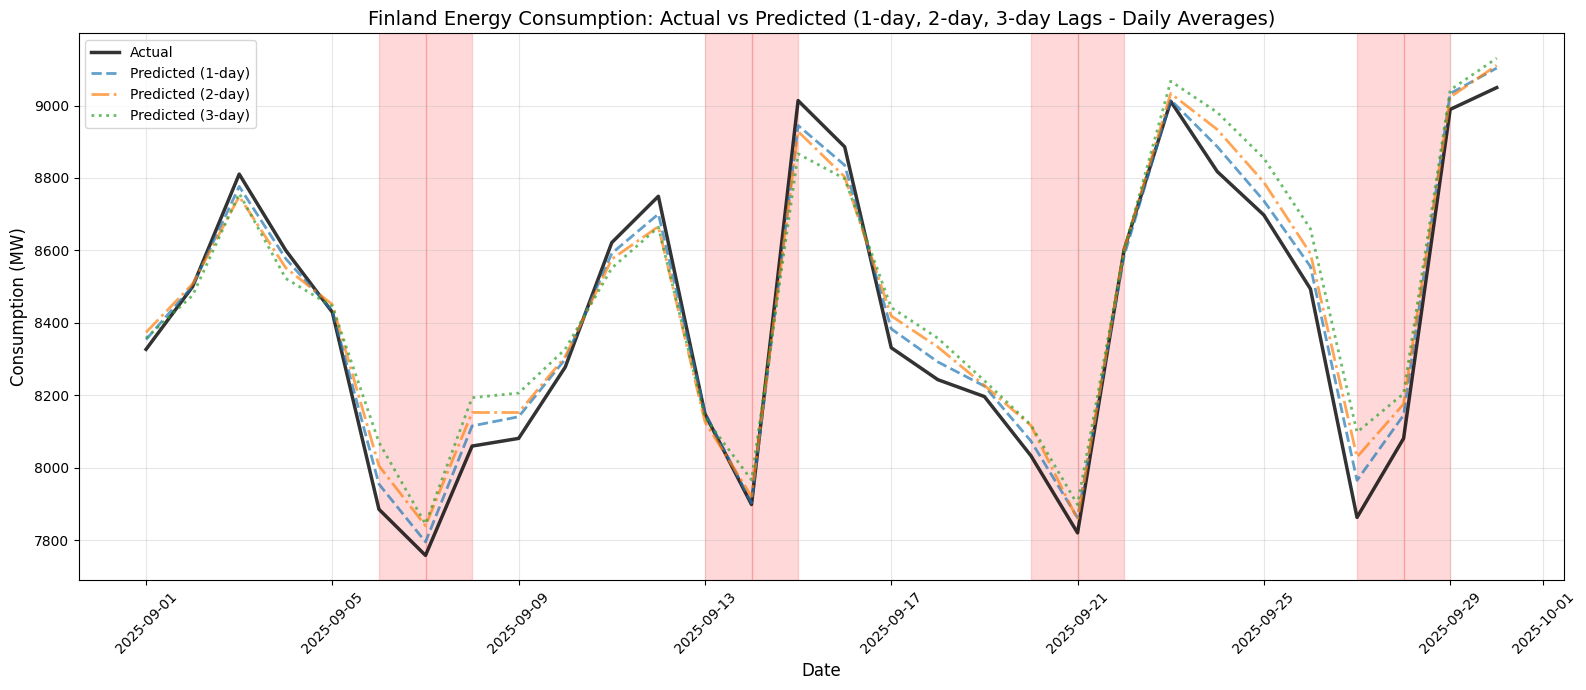

Original samples: 14394, Daily averages shown: 30
Plot saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/energy_consumption_predictions_with_lags.png
(Pale red background indicates weekends)


In [99]:
# Plot predictions vs actual (resampled to daily averages for clarity)
# Resample to daily averages to make the plot readable
df['date'] = pd.to_datetime(df['date'])
df_daily = df.set_index('date').resample('D').mean().reset_index()

# Add weekend flag to daily data
df_daily['is_weekend'] = df_daily['date'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

plt.figure(figsize=(16, 7))

# Highlight weekends with pale red background
for i in range(len(df_daily) - 1):
    if df_daily.iloc[i]['is_weekend']:
        plt.axvspan(df_daily.iloc[i]['date'], df_daily.iloc[i+1]['date'], 
                    alpha=0.15, color='red', zorder=0)

# Plot actual consumption
plt.plot(df_daily['date'], df_daily['consumption_mw'], label='Actual', linewidth=2.5, alpha=0.8, color='black')

# Plot predictions from all 3 models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
linestyles = ['--', '-.', ':']
for (lag_name, y_pred_temp), color, linestyle in zip(predictions.items(), colors, linestyles):
    plt.plot(df_daily['date'], df_daily[f'predicted_{lag_name}'], 
             label=f'Predicted ({lag_name})', linewidth=2, alpha=0.7, 
             color=color, linestyle=linestyle)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Consumption (MW)', fontsize=12)
plt.title('Finland Energy Consumption: Actual vs Predicted (1-day, 2-day, 3-day Lags - Daily Averages)', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plot_path = f"{root_dir}/docs/fingrid/assets/img/energy_consumption_predictions_with_lags.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Original samples: {len(df)}, Daily averages shown: {len(df_daily)}")
print(f"Plot saved to: {plot_path}")
print(f"(Pale red background indicates weekends)")

In [100]:
# Detailed analysis of test set performance for all 3 models
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')

# Get first and last week of test set
first_week = df_sorted[df_sorted['date'] < df_sorted['date'].min() + pd.Timedelta(days=7)]
last_week = df_sorted[df_sorted['date'] >= df_sorted['date'].max() - pd.Timedelta(days=7)]

print("Test Set Performance Analysis (WITH LAG FEATURES):")
print("=" * 80)

for lag_name in lag_configs.keys():
    pred_col = f'predicted_{lag_name}'
    print(f"\n{lag_name.upper()} LAG MODEL:")
    print("-" * 40)
    
    print(f"First week ({first_week['date'].min().date()} to {first_week['date'].max().date()}):")
    if len(first_week) > 0:
        mae = mean_absolute_error(first_week['consumption_mw'], first_week[pred_col])
        mean_err = (first_week['consumption_mw'] - first_week[pred_col]).mean()
        print(f"  MAE: {mae:.0f} MW")
        print(f"  Mean error: {mean_err:.0f} MW")
    
    print(f"\nLast week ({last_week['date'].min().date()} to {last_week['date'].max().date()}):")
    if len(last_week) > 0:
        mae = mean_absolute_error(last_week['consumption_mw'], last_week[pred_col])
        mean_err = (last_week['consumption_mw'] - last_week[pred_col]).mean()
        print(f"  MAE: {mae:.0f} MW")
        print(f"  Mean error: {mean_err:.0f} MW")

# Sample some predictions
print("\n" + "=" * 80)
print("Sample predictions (last 10 timestamps):")
print(df_sorted[['date', 'consumption_mw', 'predicted_1-day', 'predicted_2-day', 'predicted_3-day']].tail(10))

Test Set Performance Analysis (WITH LAG FEATURES):

1-DAY LAG MODEL:
----------------------------------------
First week (2025-09-01 to 2025-09-07):
  MAE: 105 MW
  Mean error: -12 MW

Last week (2025-09-23 to 2025-09-30):
  MAE: 136 MW
  Mean error: -62 MW

2-DAY LAG MODEL:
----------------------------------------
First week (2025-09-01 to 2025-09-07):
  MAE: 142 MW
  Mean error: -24 MW

Last week (2025-09-23 to 2025-09-30):
  MAE: 180 MW
  Mean error: -94 MW

3-DAY LAG MODEL:
----------------------------------------
First week (2025-09-01 to 2025-09-07):
  MAE: 169 MW
  Mean error: -23 MW

Last week (2025-09-23 to 2025-09-30):
  MAE: 221 MW
  Mean error: -140 MW

Sample predictions (last 10 timestamps):
                     date  consumption_mw  predicted_1-day  predicted_2-day  \
14384 2025-09-30 23:30:00          8614.7      8441.224609      8396.812500   
14385 2025-09-30 23:33:00          8572.0      8434.672852      8396.812500   
14386 2025-09-30 23:36:00          8486.7      8

---

## <span style="color:#ff5f27;">Feature Importance Analysis</span>

In [101]:
# Get feature importance from all 3 models
print("Feature Importance by Lag Type:")
print("="*80)

for lag_name, model in models.items():
    print(f"\n{lag_name} Lag Model - Top 10 Features:")
    feature_cols = [col for col in X_features.columns if 'lag' not in col] + lag_configs[lag_name]
    
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10))
    print()

Feature Importance by Lag Type:

1-day Lag Model - Top 10 Features:
                feature  importance
15  consumption_lag_24h    0.961917
3                  hour    0.010534
14  shortwave_radiation    0.005264
4           day_of_week    0.005053
6          week_of_year    0.003013
7        temperature_2m    0.002248
0                  year    0.002114
1                 month    0.001641
13     surface_pressure    0.001481
12   wind_direction_10m    0.001278


2-day Lag Model - Top 10 Features:
                feature  importance
15  consumption_lag_48h    0.898765
3                  hour    0.030498
14  shortwave_radiation    0.017300
4           day_of_week    0.014785
6          week_of_year    0.006916
7        temperature_2m    0.005582
0                  year    0.005359
1                 month    0.003239
13     surface_pressure    0.003220
11      wind_speed_100m    0.002876


3-day Lag Model - Top 10 Features:
                feature  importance
15  consumption_lag_72h    0.8

In [102]:
# Check correlation between features and target (using cleaned features)
correlations = X_features.corrwith(y_train.iloc[:, 0]).abs().sort_values(ascending=False)
print("Top 20 features by correlation with consumption:")
print(correlations.head(20))

Top 20 features by correlation with consumption:
consumption_lag_24h    0.989985
consumption_lag_48h    0.973007
consumption_lag_72h    0.954674
temperature_2m         0.817731
week_of_year           0.343757
month                  0.315003
shortwave_radiation    0.277301
cloud_cover            0.266584
wind_speed_100m        0.240101
wind_speed_10m         0.229859
is_weekend             0.105487
year                   0.082573
day_of_week            0.076085
wind_direction_10m     0.066650
day                    0.063252
surface_pressure       0.058877
hour                   0.047170
precipitation          0.013597
dtype: float64


In [103]:
# Check all features and their importance
print("All features in the model:")
print(feature_importance)
print(f"\nTotal features: {len(feature_importance)}")

# Highlight lag features
lag_features = feature_importance[feature_importance['feature'].str.contains('lag', case=False)]
print(f"\nLag feature importance:")
print(lag_features)

# Identify weather features (assuming they contain 'temp', 'wind', 'precip', 'pressure', 'humidity')
weather_keywords = ['temp', 'wind', 'precip', 'pressure', 'humidity', 'weather']
weather_features = feature_importance[feature_importance['feature'].str.contains('|'.join(weather_keywords), case=False)]
print(f"\nWeather features found: {len(weather_features)}")
if len(weather_features) > 0:
    print("\nWeather feature importance:")
    print(weather_features)

All features in the model:
                feature  importance
15  consumption_lag_72h    0.836510
3                  hour    0.051442
14  shortwave_radiation    0.024997
4           day_of_week    0.024693
6          week_of_year    0.012484
7        temperature_2m    0.009896
0                  year    0.008974
13     surface_pressure    0.004728
1                 month    0.004510
11      wind_speed_100m    0.004327
12   wind_direction_10m    0.003943
10       wind_speed_10m    0.003646
9           cloud_cover    0.003581
2                   day    0.003323
8         precipitation    0.002944
5            is_weekend    0.000000

Total features: 16

Lag feature importance:
                feature  importance
15  consumption_lag_72h     0.83651

Weather features found: 6

Weather feature importance:
               feature  importance
7       temperature_2m    0.009896
13    surface_pressure    0.004728
11     wind_speed_100m    0.004327
12  wind_direction_10m    0.003943
10      wind_

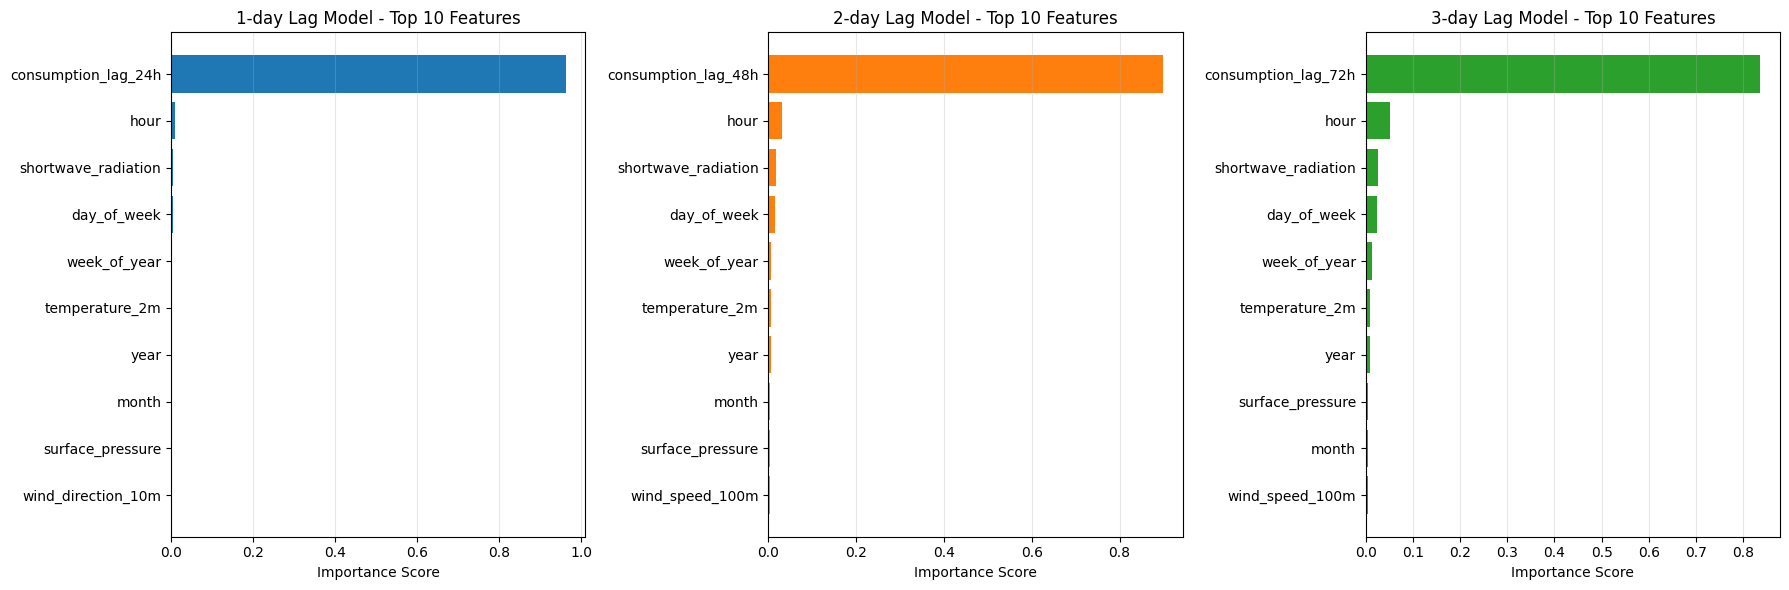

In [ ]:
# Plot feature importance for each model and save
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (lag_name, model) in enumerate(models.items()):
    feature_cols = [col for col in X_features.columns if 'lag' not in col] + lag_configs[lag_name]
    
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    top_n = 10
    top_features = feature_importance.head(top_n)
    
    axes[idx].barh(range(top_n), top_features['importance'].values, color=['#1f77b4', '#ff7f0e', '#2ca02c'][idx])
    axes[idx].set_yticks(range(top_n))
    axes[idx].set_yticklabels(top_features['feature'].values)
    axes[idx].set_xlabel('Importance Score')
    axes[idx].set_title(f'{lag_name} Lag Model - Top {top_n} Features')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save combined feature importance plot
feature_importance_path = f"{root_dir}/docs/fingrid/assets/img/feature_importance_lag_models.png"
os.makedirs(os.path.dirname(feature_importance_path), exist_ok=True)
plt.savefig(feature_importance_path, dpi=300, bbox_inches='tight')
print(f"Feature importance plot for all lag models saved to: {feature_importance_path}")

plt.show()

In [ ]:
# Plot correlation with target for each lag model and save
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, lag_name in enumerate(models.keys()):
    feature_cols = [col for col in X_features.columns if 'lag' not in col] + lag_configs[lag_name]
    X_features_subset = X_train[feature_cols]
    
    correlations = X_features_subset.corrwith(y_train.iloc[:, 0]).abs().sort_values(ascending=False)
    top_n_corr = 10
    top_correlations = correlations.head(top_n_corr)
    
    axes[idx].barh(range(len(top_correlations)), top_correlations.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'][idx])
    axes[idx].set_yticks(range(len(top_correlations)))
    axes[idx].set_yticklabels(top_correlations.index)
    axes[idx].set_xlabel('Absolute Correlation')
    axes[idx].set_title(f'{lag_name} Lag Model - Top {top_n_corr} Features by Correlation')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save combined correlation plot
correlation_path = f"{root_dir}/docs/fingrid/assets/img/feature_correlation_lag_models.png"
os.makedirs(os.path.dirname(correlation_path), exist_ok=True)
plt.savefig(correlation_path, dpi=300, bbox_inches='tight')
print(f"Feature correlation plot for all lag models saved to: {correlation_path}")

plt.show()

---

## <span style="color:#ff5f27;">Register Model to Hopsworks</span>

In [105]:
# Get model registry
mr = project.get_model_registry()

# Create model schema (input/output)
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Register all 3 models to Hopsworks
for lag_name, model in models.items():
    feature_cols = [col for col in X_features.columns if 'lag' not in col] + lag_configs[lag_name]
    X_train_subset = X_train[feature_cols]
    
    input_schema = Schema(X_train_subset)
    output_schema = Schema(y_train)
    model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
    
    # Get metrics for this model
    model_metrics = metrics[lag_name]
    
    # Create model name with underscores instead of hyphens (Hopsworks regex requirement)
    model_name = f"energy_consumption_predictor_{lag_name.replace('-', '_')}_lag"
    
    # Register model
    energy_model = mr.python.create_model(
        name=model_name,
        metrics={
            "mae": float(model_metrics['mae']),
            "mse": float(model_metrics['mse']),
            "rmse": float(model_metrics['rmse']),
            "r2": float(model_metrics['r2'])
        },
        description=f"XGBoost model with {lag_name} lag features for Finland energy consumption forecasting",
        input_example=X_train_subset.sample(n=5),
        model_schema=model_schema
    )
    
    # Save model to fingrid/energy_model directory
    import os
    import joblib
    model_dir = f"{root_dir}/fingrid/energy_model"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    model_filename = f"{model_dir}/energy_consumption_predictor_{lag_name.replace('-', '_')}_lag.pkl"
    joblib.dump(model, model_filename)
    
    energy_model.save(model_dir)
    print(f"Model with {lag_name} lag saved to: {model_filename}")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor.…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\input_example.json: 0.000%|     …

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286359/models/energy_consumption_predictor_1_day_lag/2
Model with 1-day lag saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_1_day_lag.pkl


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor.…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\input_example.json: 0.000%|     …

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286359/models/energy_consumption_predictor_2_day_lag/2
Model with 2-day lag saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_2_day_lag.pkl


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor.…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\input_example.json: 0.000%|     …

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286359/models/energy_consumption_predictor_3_day_lag/2
Model with 3-day lag saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/fingrid/energy_model/energy_consumption_predictor_3_day_lag.pkl
